# Monash Time-Series Replication

The Monash Time-Series Forecasting aims to be a repository and container of multiple model performance for multiple public datasets.

In our replication, we reconstruct part of their analysis, focusing on the summary statistics of the datasets and the results from the models.

In [54]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime

sns.set_style("whitegrid")
import os
import config
from pathlib import Path
OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
from itertools import chain
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
try:
    from tables_create import convert_tsf_to_dataframe, generate_single_dataset_info
    from data_download import download_and_extract_zip
except:
    from src.tables_create import convert_tsf_to_dataframe
    from src.data_download import download_and_extract_zip

## 1. Data Download

We start by downloading the data using the `data_download.py` file.
This file takes the zipped version of datasets from the website and downloads them into our `data` folder.

```
def download_and_extract_zip(url, destination_dir):
    response = requests.get(url)
    response.raise_for_status()
    with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
        file_list = zip_file.namelist()
        first_file_name = file_list[0]
        zip_file.extract(first_file_name, destination_dir)
    
    extracted_file_path = os.path.join(destination_dir, first_file_name)
    
    return extracted_file_path
```

Once the data is downloaded, we can work with it making the summary statistics for table 1 and results of the models for table 2.

In this notebook, we exemplify how the download works for M1 Yearly Dataset.

In [28]:
m1_monthly_dataset_location = download_and_extract_zip('https://zenodo.org/records/4656159/files/m1_monthly_dataset.zip?download=1', DATA_DIR)
print(m1_monthly_dataset_location)

/Users/fernandorochacorreaurbano/Desktop/Data Science Tools for Finance/final_project/monash-time-series-replication/data/m1_monthly_dataset.tsf


The format of the datasets is ".tsf", which includes the datasets and also information about the datasets. In this, we see:
- frequency
- forecasting horizon
- if the dataset has missing values
- if dataset contains equal length

We create a function to convert the tsf file list in actual values of a series in the dataframe.

As an example, we take a look at M1 Yearly:

In [32]:
m1_monthly_dataset_list = convert_tsf_to_dataframe(os.path.dirname(os.getcwd()) + '/data/m1_monthly_dataset.tsf')
m1_monthly_dataset_raw = m1_monthly_dataset_list[0]
m1_monthly_dataset_frequency  = m1_monthly_dataset_list[1]
m1_monthly_dataset_forecast_horizon = m1_monthly_dataset_list[2]
m1_monthly_dataset_contain_missing_values = m1_monthly_dataset_list[3]
m1_monthly_dataset_contain_equal_length = m1_monthly_dataset_list[4]
m1_monthly_dataset_raw

,series_name,start_timestamp,series_value
0,T1,1975-12-01,"[697458.0, 1187650.0, 1069690.0, 1078430.0, 10..."
1,T2,1975-07-01,"[61.61, 66.74, 71.88, 82.15, 87.28, 107.82, 12..."
2,T3,1975-04-01,"[409.0, 419.0, 339.0, 421.0, 474.0, 427.0, 452..."
3,T4,1975-04-01,"[3334.0, 3363.0, 3395.0, 3831.0, 3292.0, 5043...."
4,T5,1975-03-01,"[33.66, 30.97, 38.04, 37.31, 33.86, 37.5, 36.6..."
...,...,...,...
612,T613,1967-12-01,"[3928.0, 4830.0, 4926.0, 6465.0, 8588.0, 6843...."
613,T614,1967-12-01,"[33.0, 28.0, 40.0, 31.0, 36.0, 33.0, 50.0, 57...."
614,T615,1971-12-01,"[26.0, 24.5, 27.9, 29.1, 34.7, 33.1, 36.0, 37...."
615,T616,1958-12-01,"[55.91, 56.0, 55.45, 56.01, 55.54, 56.35, 56.4..."


In [33]:
m1_monthly_dataset = (
    m1_monthly_dataset_raw
    .assign(timestamp=lambda df: df.apply(lambda row: [(row.start_timestamp + relativedelta(months=i)).date() for i in range(0, len(row.series_value))], axis=1))
    .drop('start_timestamp', axis=1)
    .assign(timestamp_series_value=lambda df: df.apply(lambda row: list(zip(row['series_value'], row['timestamp'])), axis=1))
    .explode('timestamp_series_value')
    .assign(series_value=lambda df: df.apply(lambda row: row.timestamp_series_value[0], axis=1))
    .assign(timestamp=lambda df: df.apply(lambda row: row.timestamp_series_value[1], axis=1))
    .drop('timestamp_series_value', axis=1)
)
m1_monthly_dataset

,series_name,series_value,timestamp
0,T1,697458.0,1975-12-01
0,T1,1187650.0,1976-01-01
0,T1,1069690.0,1976-02-01
0,T1,1078430.0,1976-03-01
0,T1,1059910.0,1976-04-01
...,...,...,...
616,T617,58.0,1972-07-01
616,T617,35.0,1972-08-01
616,T617,38.0,1972-09-01
616,T617,28.0,1972-10-01


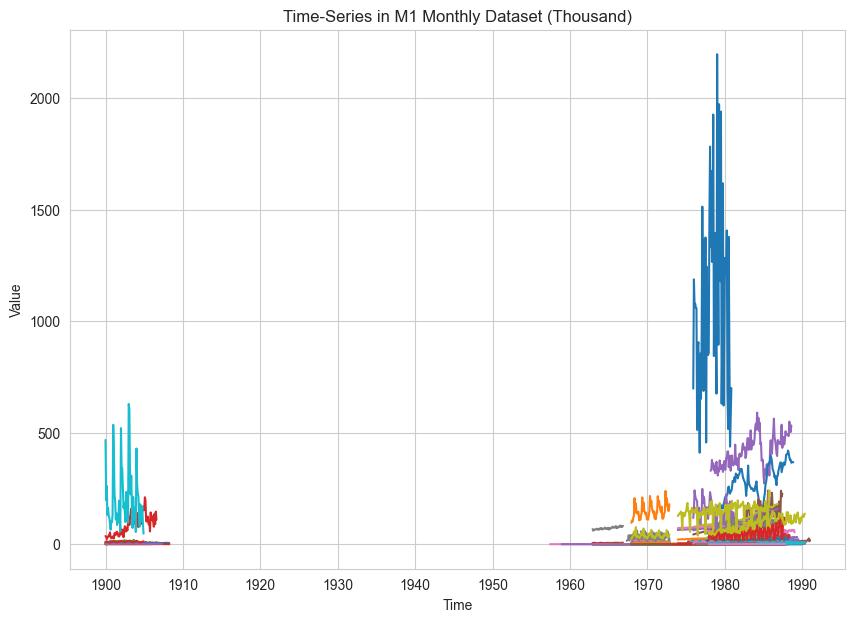

In [52]:
(
    m1_monthly_dataset
    .pivot(index='timestamp', columns='series_name', values='series_value')
    .map(lambda x: x / 1e3)
    .plot(legend=False, title='Time-Series in M1 Monthly Dataset (Thousand)', figsize=(10, 7), xlabel='Time', ylabel='Value')
);

As we can see, M1 has a considerable diversity of series, with different values and in completely different timeframes. For instance:

<Axes: title={'center': 'T4 Series Value'}, xlabel='Time', ylabel='Value'>

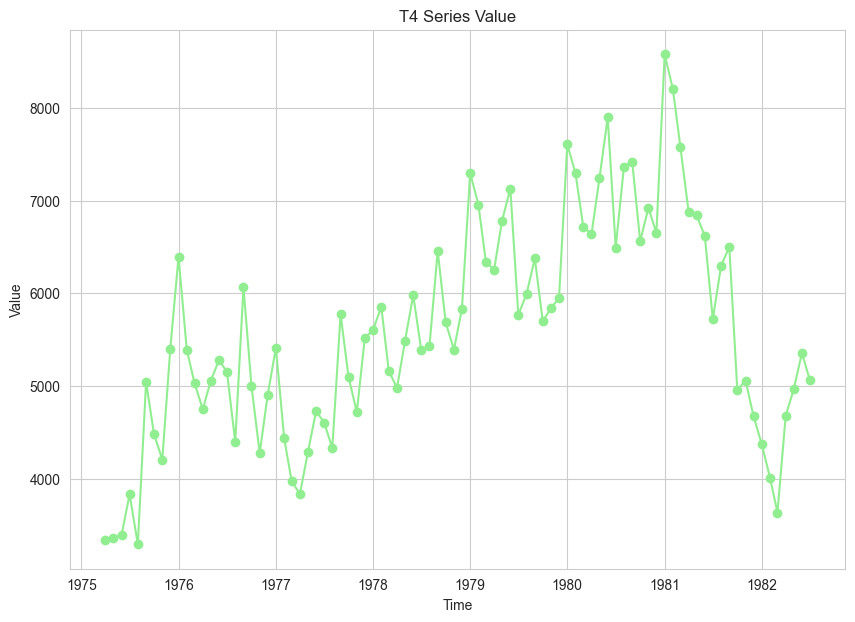

In [60]:
(    
    m1_monthly_dataset.loc[lambda df: df.series_name == 'T4']
    .set_index('timestamp')
    .loc[:, 'series_value']
    .plot(legend=False, title='T4 Series Value', figsize=(10, 7), xlabel='Time', ylabel='Value', marker='o', color='lightgreen')
)

## 2. Table 1
The table 1 generates a summary of the dataframe values and specifications.

It reads every single dataset from our analysis and construct general statistics about the time-series in it as well as general dataset information.

For the following example, the following three datasets must be downloaded:

```
'm1_monthly_dataset.tsf',
'm1_quarterly_dataset.tsf',
'm1_quarterly_dataset.tsf'
```

The results are generated using the `generate_single_dataset_info` and after joining all of them.

As an example of `generate_single_dataset_info`, the next jupyter notebook cell should generate a result like the following:

```
{
    'Domain': 'Multiple',
    'No: of Series': 1023,
    'Min. Length': 18,
    'Max. Length': 150,
    'No: of Freq': 3,
    'Missing': False,
    'Competition': True,
    'Multivariate': False
 }
 ```

In [59]:
m1_monthly_dataset_location = download_and_extract_zip('https://zenodo.org/records/4656159/files/m1_monthly_dataset.zip?download=1', DATA_DIR)
m1_yearly_dataset_location = download_and_extract_zip('https://zenodo.org/records/4656193/files/m1_yearly_dataset.zip?download=1', DATA_DIR)
m1_quarterly_dataset_location = download_and_extract_zip('https://zenodo.org/records/4656154/files/m1_quarterly_dataset.zip?download=1', DATA_DIR)

DATASETS_TO_INFO = {
    'M1': {
        'Domain': 'Multiple',
        'Datasets': [
            'm1_monthly_dataset.tsf',
            'm1_quarterly_dataset.tsf',
            'm1_quarterly_dataset.tsf'
        ],
        'Multivariate': False
    },
}

for dataset_name, info in DATASETS_TO_INFO.items():
    information = generate_single_dataset_info(dataset_name, info)
information

{'Domain': 'Multiple',
 'No: of Series': 1023,
 'Min. Length': 18,
 'Max. Length': 150,
 'No: of Freq': 3,
 'Missing': False,
 'Competition': True,
 'Multivariate': False}

After generating the results for all the files, table 1 is generated as `csv` and `xlsx` files to later be added in the latex file.

## 3. Table 2

Table 2 has no relation to table 2 and can be generated independently of table 1.

For table 2, we only need to run the `src/experiments/fixed_horizon.R`.

Inside this R file, we have all the models for each dataset to be generated.